In [1]:
import os
import torch

import matplotlib.pyplot as plt
from tqdm import trange
from models.ESN import ESNModel
from dataset.data_loaders import load_dataset, generate_datasets
from models.early_stopping import EarlyStopping


os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Data

In [2]:
data, L, F = load_dataset('spain')

Xtr, Ytr, Xval, Yval, Xte, Yte, diffXte, diffYte = generate_datasets(data, L, F, device, test_percent = 0.25, val_percent = 0.25)


In [10]:
batch = 1
steps = Xtr[:,0].shape[0]

X = torch.stack([Xtr[i:i+batch,0] for i in range(steps-batch+1)])[...,None,None]
Xv = torch.stack([Xval[i:i+batch,0] for i in range(Xval.shape[0]-batch+1)])[...,None,None]
Xt = torch.stack([Xte[i:i+batch,0] for i in range(Xte.shape[0]-batch+1)])[...,None,None]

Y = Ytr[batch-F:,].squeeze()
Yv = Yval[batch-F:,].squeeze()
Yt = Yte[batch-F:,].squeeze()

In [11]:
X.shape

torch.Size([907, 1, 1, 1])

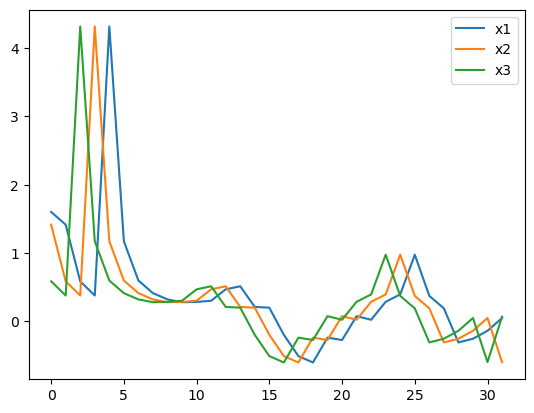

In [5]:
plt.plot(X[0].squeeze().cpu(), label='x1')
plt.plot(X[1].squeeze().cpu(), label='x2')
plt.plot(X[2].squeeze().cpu(), label='x3')
# plt.plot(torch.concat([torch.zeros_like(Ytr[31:63,].squeeze().cpu()),Ytr[31:63,].squeeze().cpu()]), label='y')
# plt.plot(Ytr[:32,].squeeze().cpu(), label='y')
# plt.plot(Xtr[:64,0].cpu(), linestyle=':', label='x')
plt.legend()

In [12]:
esn = ESNModel(1, 500, 1, 0, 1, F).to(device)

In [13]:
esn(X).shape

torch.Size([907, 1, 1, 1])

In [14]:
torch_optimizer = torch.optim.Adam(esn.parameters(), lr=0.01, weight_decay=1e-5)
epochs = 100
torch_loss = torch.nn.MSELoss()

# initialize the early_stopping object
checkpoint_path = "./checkpoints/esn/"
early_stopping = EarlyStopping(patience=20, verbose=False, path=checkpoint_path)

with trange(epochs) as t:
    for epoch in t:
        esn.train()
        torch_optimizer.zero_grad()
        loss = torch_loss(esn(X).squeeze(), Y.squeeze())
        loss.backward()
        torch_optimizer.step()

        # display progress bar
        t.set_description(f"Epoch {epoch+1}")
        t.set_postfix({"loss":float(loss / Y.shape[0])})

        # Early stopping
        esn.eval()
        valid_loss = torch_loss(esn(Xv).squeeze(), Yv.squeeze()).item()

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, esn)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

# load the last checkpoint with the best model
esn.load_state_dict(torch.load(checkpoint_path + "checkpoint.pt"))

Epoch 70:  69%|██████▉   | 69/100 [00:00<00:00, 189.20it/s, loss=0.000518]

Early stopping


<All keys matched successfully>

In [15]:
out = esn(Xt).squeeze().detach().cpu()

In [16]:
out.shape

torch.Size([455])

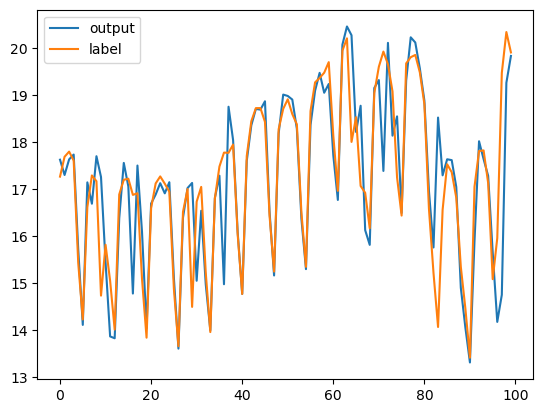

In [17]:
plt.plot((out+diffYte[batch-F:,].squeeze().cpu())[:100], label='output')
plt.plot((Yt.cpu()+diffYte[batch-F:,].squeeze().cpu())[:100].squeeze().cpu(), label='label')
plt.legend()

## Reservoir states

In [18]:
h = esn.reservoir(Xt, return_last_state=False)

In [19]:
h.shape

torch.Size([455, 1, 1, 500])

# Naif approach

In [60]:
class linear(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linear, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out

In [113]:
x_dmd = h.squeeze()[:200]
y_dmd = h.squeeze()[1:201]

dmd_model = linear(500,500).to(device)

dmd_loss = torch.nn.MSELoss() 
dmd_optimizer = torch.optim.SGD(dmd_model.parameters(), lr=0.01)

with trange(epochs) as t:
    for epoch in t:
        dmd_model.train()
        dmd_optimizer.zero_grad()
        loss = dmd_loss(dmd_model(x_dmd).squeeze(), y_dmd.squeeze())
        loss.backward()
        dmd_optimizer.step()

        # display progress bar
        t.set_description(f"Epoch {epoch+1}")
        t.set_postfix({"loss":float(loss / y_dmd.shape[0])})

Epoch 100: 100%|██████████| 100/100 [00:00<00:00, 309.18it/s, loss=0.00116]


In [114]:
dmd_model.eval()

x_dmd_te = h.squeeze()[200:-1]
y_dmd_te = h.squeeze()[201:]

dmd_loss(dmd_model(x_dmd_te).squeeze(), y_dmd_te.squeeze())

tensor(0.2021, device='cuda:0', grad_fn=<MseLossBackward0>)

In [47]:
y_dmd_te.shape

torch.Size([254, 500])

In [68]:
x_dmd_te.shape

torch.Size([254, 500])

In [115]:
A = next(dmd_model.linear.parameters())

In [127]:
accs = [dmd_loss(torch.pow(A, 1) @ x_dmd_te.T, y_dmd_te.T.squeeze()).detach().cpu()]

# FIXME
for i in range(1, y_dmd_te.shape[0]):
    accs.append(dmd_loss(torch.pow(A, i+1) @ x_dmd_te[:-i].T, y_dmd_te[i:].T.squeeze()).detach().cpu())

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


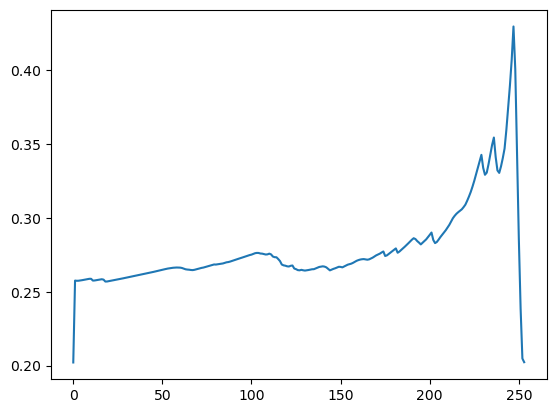

In [128]:
plt.plot(accs)